In [22]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff


# Simulate Data

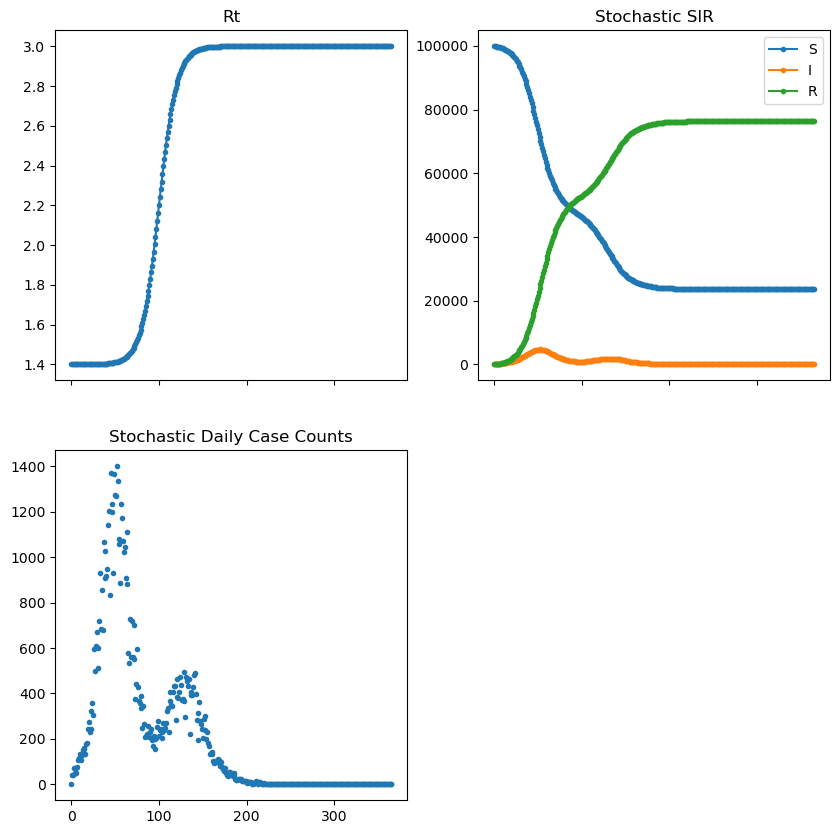

In [23]:
import importlib
import simulate_data
importlib.reload(simulate_data)

true_params = {
    'rt_0': 1.4,
    'rt_1': 3.,
    'midpoint': 100.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}


np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

data.plot_all()

# EAKF

In [24]:
import collections

SIR = collections.namedtuple(
  typename='SIRComponents',
  field_names=[
    'S',              # S
    'I',               # I
    'R',                # R
    'i'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'beta',                        # Beta
      't_I'   # t_I = 1/gamma
    ]
)

In [25]:
beta = data.construct_beta(data.rt, data.t_I)

x = SIR(
    S = data.S0,
    I = data.I0,
    R = 0,
    i = 0
)
θ = ModelParams(beta, data.t_I)

In [26]:
def f(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    dSI = np.random.poisson(x.S * x.I/ N * θ.beta) # susceptible to infected
    dIR = np.random.poisson(x.I / θ.t_I) # infected to recovered
    
    # OEV = np.maximum(1., dSI**2 * noise_param)
    # OEV_sample= np.random.normal(0, 1, size=len(dSI))
    # i_noise = dSI + OEV_sample * np.sqrt(OEV)

    # Updates
    x_new = SIR(
        S = np.clip(x.S - dSI, 0, N),
        I = np.clip(x.I + dSI - dIR, 0, N),
        R = np.clip(x.R + dIR, 0, N),
        i = np.clip(dSI, 0, N)
    )

    return x_new

def g(x, α):
    """
    Observational function.
        Args:
            x: state space
            α: report rate
    """
    # y = np.random.binomial(x.i.astype(int), α)
    return x.i

def f0(pop, m=300):
    """
    Initial guess of the state space.
        Args:
            pop: population
            m: number of ensemble members
    """
#     I0 = pop * inf_init
#     S0 = pop - I0
#     R0 = 0
#     i = 0

    S0 = np.random.uniform(pop*0.8, pop, size=m)
    I0 = pop - S0
    R0 = np.zeros(m)
    i0 = np.zeros(m)
    
    x0 = SIR(
        S = S0,
        I = I0,
        R = R0,
        i = i0
    )
    return x0

def θ0(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta = prior['beta']['dist'](**prior['beta']['args'], size=m)
    θ0 = ModelParams(beta=beta, t_I=np.ones(m)*data.t_I)
    return θ0

In [27]:
def eakf(x, y, z, oev):
    """
    Args:
        x: latenet state rv or latent parameter rv
        y: observed rv
        z: observation
        oev: observational error variance
    """
    x = np.array(x)
    y = np.array(y)
    
    p, m = x.shape

    mu_prior  = y.mean()
    var_prior = y.var()

    # degenerate prior.
    var_prior = np.where(var_prior == 0., 1e-3, var_prior)

    var_post = var_prior * oev / (var_prior + oev)
    mu_post  = var_post  * (mu_prior/var_prior + z/oev)
    alpha    = (oev / (oev + var_prior)) ** (0.5)
    dy       = (mu_post - y) + alpha * (y - mu_prior)
    
    # compute covariance
    rr = np.full((p, 1), np.nan)

    # import pdb; pdb.set_trace()
    for ip in range(p):
        A  = np.cov(x[ip, :], y)
        rr[ip,:] =  A[1, 0] / var_prior
    dx = np.dot(rr, dy.reshape((1,300)))
    # rr = np.cov(x, y)[:-1,-1] / var_prior
    # dx_new = np.dot(rr.reshape((4,1)), dy.reshape((1,300)))

    xpost = x + dx
    ypost = y + dy

    return xpost, ypost

In [28]:
from numpy.random import uniform

prior = {
    'beta':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    't_I':{
        'dist': "constant",
        # 'args':{
        #     'lower': 1.,
        #     'upper': 12.,
        # }
    },
}



In [93]:
def plot_reliability(θ_list):
    post_θ = np.asarray(θ_list)[-1,:,:]

    m,n = post_θ.shape
    nsample = 1000
    idx = np.random.randint(0,m,nsample)
    out = post_θ[:,idx]
    
    post_pred = []
    
    def free_sim(beta, I0):
        S = np.array([data.S0 * np.ones(300)])
        Ir = np.array([data.I0 * np.ones(300)])
        R = np.array([np.zeros(300)])
        i = np.array([np.zeros(300)])

        for t in range(data.n_t):
            if t < 20:
                dSI = np.random.poisson(0.35*Ir[t]*S[t]/data.N)
            else:
                dSI = np.random.poisson(beta[t]*Ir[t]*S[t]/data.N)
            dIR = np.random.poisson(Ir[t]/data.t_I)

            S_new = np.clip(S[t]-dSI, 0, data.N)
            I_new = np.clip(Ir[t]+dSI-dIR, 0, data.N)
            R_new = np.clip(R[t]+dIR, 0, data.N)

            S = np.append(S, [S_new], axis=0)
            Ir = np.append(Ir, [I_new], axis=0)
            R = np.append(R, [R_new], axis=0)
            i = np.append(i, [dSI], axis=0)
        
        return S, Ir, R, i
        
    S, Ir, R, i = free_sim(betas, I0s)
    post_pred = i.copy()
    lower = np.quantile(post_pred, q = [0.025, 0.975], axis=1)[0,:]
    upper = np.quantile(post_pred, q = [0.025, 0.975], axis=1)[1,:]
    
    lower_50 = np.quantile(post_pred, q = [0.25, 0.75], axis=1)[0,:]
    upper_50 = np.quantile(post_pred, q = [0.25, 0.75], axis=1)[1,:]
    
    fig, ax = plt.subplots(1)

    ax.plot(data.i, '.')
    ax.plot(np.arange(0,366), np.mean(post_pred, axis=1), label='post mean', color='black', ls='--')
    ax.fill_between(np.arange(0,366), lower, upper, facecolor='gray', alpha=0.5,
                    label='95% CI')
    ax.fill_between(np.arange(0,366), lower_50, upper_50, facecolor='gray', alpha=0.95,
                    label='50% CI')
    ax.legend(loc='upper left')
    
    prop_95 = np.mean((lower <= data.i) & (data.i <= upper))
    prop_50 = np.mean((lower_50 <= data.i) & (data.i <= upper_50))

    print(f"Percent of observations in 95% CI {round(prop_95*100, 2)}%")
    print(f"Percent of observations in 50% CI {round(prop_50*100, 2)}%")
    
    prop_list = []
    for p in range(5,100,5):
        lower = np.quantile(post_pred, q = [(1-p/100)/2, 1-(1-p/100)/2], axis=1)[0,:]
        upper = np.quantile(post_pred, q = [(1-p/100)/2, 1-(1-p/100)/2], axis=1)[1,:]
        prop_list.append(np.mean((lower <= data.i) & (data.i <= upper)))
    
    fig, ax = plt.subplots(1)
    ax.plot(np.arange(5,100,5)/100, prop_list)
    ax.axline((0, 0), (1, 1), color='r')
    ax.set_xlabel('CI')
    ax.set_ylabel('% of obs within CI')

## Run filter entire time series to learn $\beta(t)$

In [94]:
from tqdm import tqdm

from scipy.stats import norm

x_list = []
prior_list = []
innovation_list = []
threshold_list = []
θ_list = []

for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N)
        θ = θ0(prior)
    else:
        x = f(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        prior_list.append(x)
        # noise_param = 1/100
        # oev = np.random.normal(0, 1) * np.maximum(1., z * noise_param)
        oev = np.maximum(10, z**2/50)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        innovation = (z - x.i)/(z+1)
        innovation_list.append(innovation)
        
        # threshold = np.sqrt(oev)*norm.ppf(0.99)/(z+1)
        threshold = np.sqrt(oev)*norm.ppf(0.99)/(z+1)
        threshold_list.append(threshold)
        
        θ, _ = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

Text(0.5, 0.98, 'EAKF full time series no inflation')

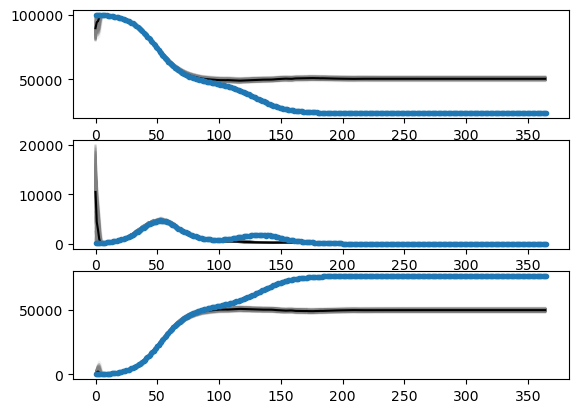

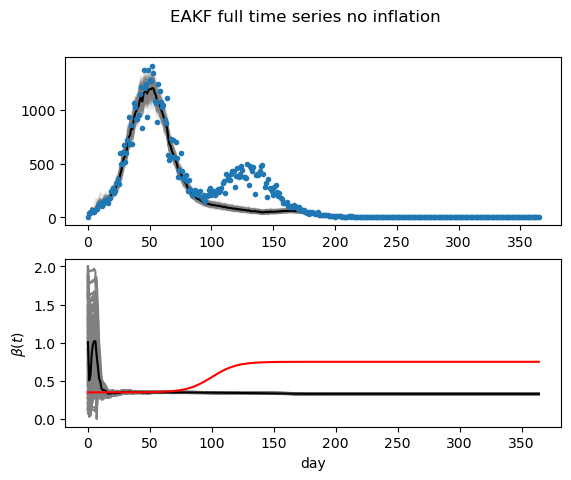

In [95]:
fig, ax = plt.subplots(3)
ax[0].plot([x.S for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.S for x in x_list], axis=1), color='black')
ax[0].plot(data.S, '.')

ax[1].plot([x.I for x in x_list], color='gray', alpha=0.1)
ax[1].plot(np.mean([x.I for x in x_list], axis=1), color='black')
ax[1].plot(data.I, '.')

ax[2].plot([x.R for x in x_list], color='gray', alpha=0.1)
ax[2].plot(np.mean([x.R for x in x_list], axis=1), color='black')
ax[2].plot(data.R, '.')

fig, ax = plt.subplots(2)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')

ax[1].plot([θ.beta for θ in θ_list], color="gray")
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].plot(beta, color="red")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('EAKF full time series no inflation')

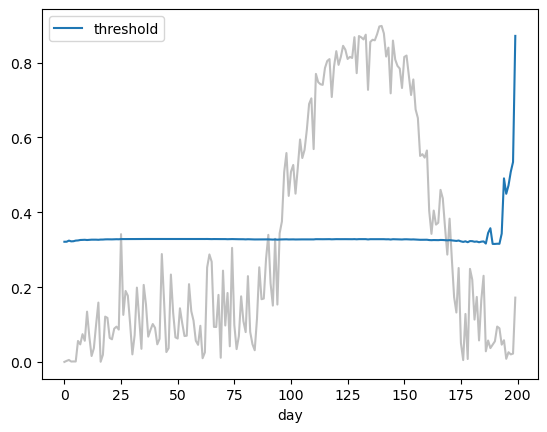

In [96]:
innovations = np.abs(np.mean(np.array(innovation_list), axis=1))
thresholds = np.abs(np.array(threshold_list))

fig, ax = plt.subplots()
ax.plot(innovations[:200], color="gray", alpha=0.5)
ax.plot(thresholds[:200], label="threshold")
ax.set_xlabel("day")
ax.legend()

In [97]:
np.where(innovations > thresholds)

(array([ 25,  90,  93,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170]),)

In [98]:
from tqdm import tqdm

x_list_2 = []
θ_list_2 = []

changepoint = 90

for t in range(changepoint, data.n_t):
    if t == changepoint:
        # x = x_list[-1]
        # x = inflate_ensembles(np.asarray(x))
        # x = SIR(*x)
        # θ = θ_list[-1]
        # θ = inflate_ensembles(np.asarray(θ))
        # θ = ModelParams(*θ)
        x = SIR(
            S = data.S[changepoint] + np.random.normal(0,10,300),
            I = data.I[changepoint] + np.random.normal(0,10,300),
            R = data.R[changepoint] + np.random.normal(0,10,300),
            i = data.i[changepoint] + np.random.normal(0,10,300)
        )
        θ = θ0(prior)
    else:
        if (50 < t) & (t < 200) & (t % 2 == 0):
            # x = SIR(*inflate_ensembles(x, inflation_value=1.2))
            # x = SIR(
            #     S = np.clip(x.S, 0, data.N),
            #     I = np.clip(x.I, 0, data.N),
            #     R = np.clip(x.R, 0, data.N),
            #     i = np.clip(x.i, 0, data.N)
            # )
            θ = inflate_ensembles(θ, inflation_value=1.2)
            θ = np.clip(θ, 0, 10)
            θ = ModelParams(*θ)
        x = f(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        
        oev = np.maximum(10, z**2/50)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        θ, _ = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    x_list_2.append(x)
    θ_list_2.append(θ)

Text(0.5, 0.98, 'EAKF second half time series inflation 20%')

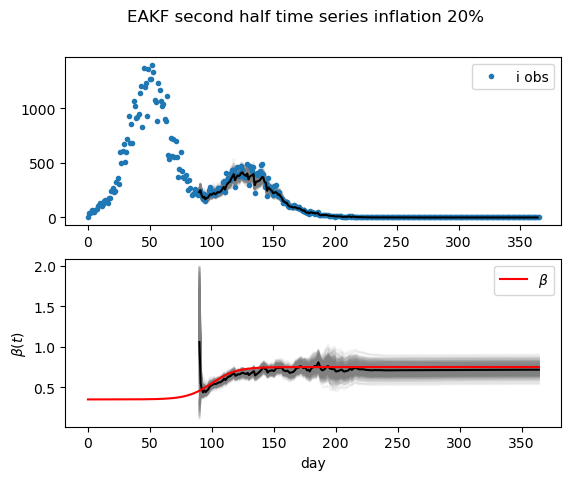

In [99]:
fig, ax = plt.subplots(2)
ax[0].plot(np.arange(changepoint, data.n_t), [x.i for x in x_list_2], color='gray', alpha=0.1)
ax[0].plot(data.i, '.', label="i obs")
ax[0].plot(np.arange(changepoint, data.n_t), np.mean([x.i for x in x_list_2], axis=1), color='black')
ax[0].legend()

ax[1].plot(np.arange(changepoint, data.n_t), [θ.beta for θ in θ_list_2], color="gray", alpha=0.1)
ax[1].plot(np.arange(changepoint, data.n_t), np.mean([θ.beta for θ in θ_list_2], axis=1), color="black")
ax[1].plot(beta, color="red", label=r"$\beta$")
ax[1].legend()
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('EAKF second half time series inflation 20%')

Text(0.5, 1.0, 'free simulation')

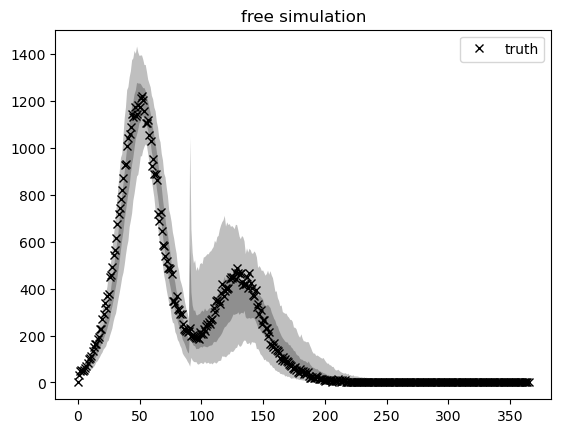

In [100]:
betas1 = np.asarray([θ.beta for θ in θ_list])[:changepoint]
betas2 = np.asarray([θ.beta for θ in θ_list_2])
betas = np.append(betas1, betas2, axis=0)
I0s = np.asarray(x_list[0].I)

def free_sim(beta, I0):
    S = np.array([data.S0 * np.ones(300)])
    Ir = np.array([data.I0 * np.ones(300)])
    R = np.array([np.zeros(300)])
    i = np.array([np.zeros(300)])
    
    for t in range(data.n_t):
        if t < 20:
            dSI = np.random.poisson(0.35*Ir[t]*S[t]/data.N)
        else:
            dSI = np.random.poisson(beta[t]*Ir[t]*S[t]/data.N)
        dIR = np.random.poisson(Ir[t]/data.t_I)

        S_new = np.clip(S[t]-dSI, 0, data.N)
        I_new = np.clip(Ir[t]+dSI-dIR, 0, data.N)
        R_new = np.clip(R[t]+dIR, 0, data.N)

        S = np.append(S, [S_new], axis=0)
        Ir = np.append(Ir, [I_new], axis=0)
        R = np.append(R, [R_new], axis=0)
        i = np.append(i, [dSI], axis=0)


    return S, Ir, R, i

S, Ir, R, i = free_sim(betas, I0s)

ci = np.quantile(i, q=[0.025, 0.975], axis=1)

ci_50 = np.quantile(i, q=[0.25, 0.75], axis=1)

# plt.plot(i, '-.', alpha=0.1, color='grey')
plt.fill_between(np.arange(0,366), ci[0], ci[1], facecolor='gray', alpha=0.5)
plt.fill_between(np.arange(0,366), ci_50[0], ci_50[1], facecolor='gray', alpha=0.75)
plt.plot(data.i_true, 'x', color='black', label="truth")
plt.legend()

plt.title("free simulation")

Percent of observations in 95% CI 89.34%
Percent of observations in 50% CI 59.56%


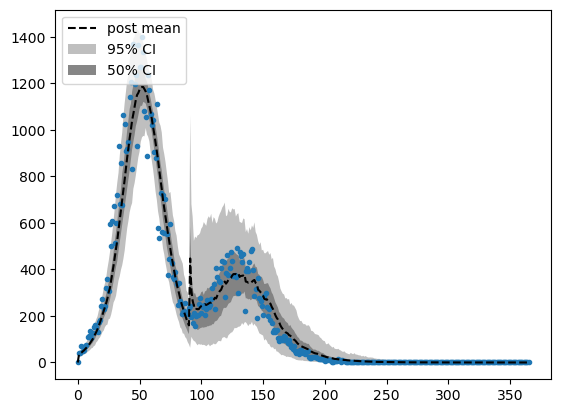

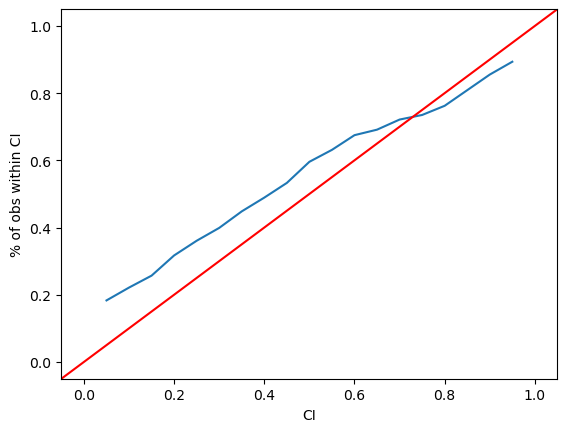

In [101]:
plot_reliability(np.append(np.asarray(θ_list[:changepoint]), np.asarray(θ_list_2), axis=0))

### Try adding some inflation

Inflate variance of parameter ensemble by 20% every other day between days 50 and 200. 

In [102]:
def inflate_ensembles(ens, inflation_value=1.2):
    _, m = np.asarray(ens).shape
    ens_mean = np.mean(ens, 1, keepdims=True)
    return ens_mean * np.ones((1,m)) + inflation_value*(ens - ens_mean*np.ones((1,m)))

In [103]:
from tqdm import tqdm

from scipy.stats import norm

x_list = []
prior_list = []
innovation_list = []
threshold_list = []
θ_list = []

for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N)
        θ = θ0(prior)
    else:
        if (50 < t) & (t < 200) & (t % 2 == 0):
            # x = SIR(*inflate_ensembles(x, inflation_value=1.2))
            # x = SIR(
            #     S = np.clip(x.S, 0, data.N),
            #     I = np.clip(x.I, 0, data.N),
            #     R = np.clip(x.R, 0, data.N),
            #     i = np.clip(x.i, 0, data.N)
            # )
            θ = inflate_ensembles(θ, inflation_value=1.2)
            θ = np.clip(θ, 0, 10)
            θ = ModelParams(*θ)
        x = f(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        prior_list.append(x)
        # noise_param = 1/100
        # oev = np.random.normal(0, 1) * np.maximum(1., z * noise_param)
        oev = np.maximum(10, z**2/50)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        innovation = (z - x.i)/(z+1)
        innovation_list.append(innovation)
        
        # threshold = np.sqrt(oev)*norm.ppf(0.99)/(z+1)
        threshold = np.sqrt(oev)*norm.ppf(0.99)/(z+1)
        threshold_list.append(threshold)
        
        θ, _ = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

In [104]:
from tqdm import tqdm

x_list = []
θ_list = []

for t, date in tqdm(enumerate(range(data.n_t))):
    if t == 0:
        x = f0(data.N)
        θ = θ0(prior)
    else:
        if (50 < t) & (t < 200) & (t % 2 == 0):
            # x = SIR(*inflate_ensembles(x, inflation_value=1.2))
            # x = SIR(
            #     S = np.clip(x.S, 0, data.N),
            #     I = np.clip(x.I, 0, data.N),
            #     R = np.clip(x.R, 0, data.N),
            #     i = np.clip(x.i, 0, data.N)
            # )
            θ = inflate_ensembles(θ, inflation_value=1.2)
            θ = np.clip(θ, 0, 10)
            θ = ModelParams(*θ)
            
        x = f(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        
        oev = np.maximum(10, z**2/50)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        θ, _ = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

365it [00:00, 2585.92it/s]


Text(0.5, 0.98, 'EAKF full time series with inflation 20%')

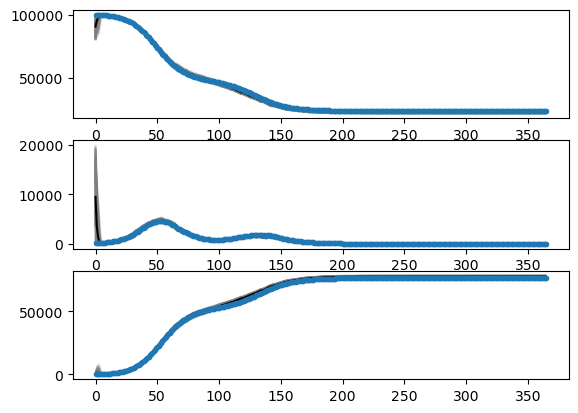

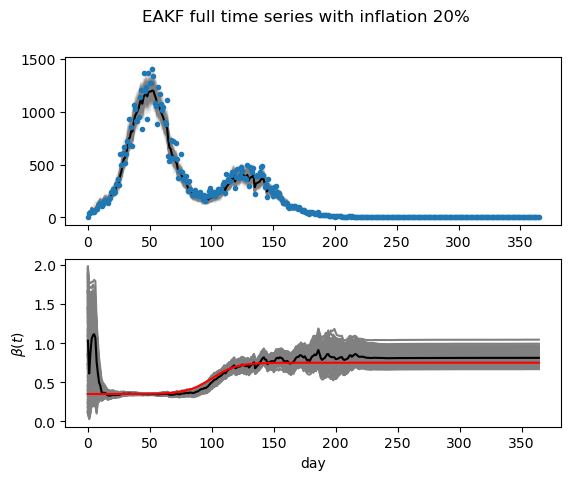

In [105]:
fig, ax = plt.subplots(3)
ax[0].plot([x.S for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.S for x in x_list], axis=1), color='black')
ax[0].plot(data.S, '.')

ax[1].plot([x.I for x in x_list], color='gray', alpha=0.1)
ax[1].plot(np.mean([x.I for x in x_list], axis=1), color='black')
ax[1].plot(data.I, '.')

ax[2].plot([x.R for x in x_list], color='gray', alpha=0.1)
ax[2].plot(np.mean([x.R for x in x_list], axis=1), color='black')
ax[2].plot(data.R, '.')

fig, ax = plt.subplots(2)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')

ax[1].plot([θ.beta for θ in θ_list], color="gray")
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].plot(beta, color="red")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('EAKF full time series with inflation 20%')

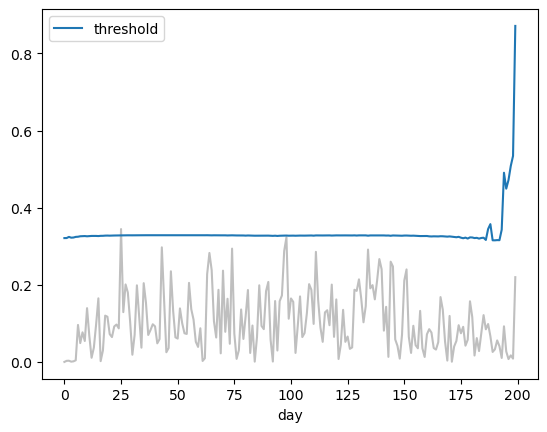

In [106]:
innovations = np.abs(np.mean(np.array(innovation_list), axis=1))
thresholds = np.abs(np.array(threshold_list))

fig, ax = plt.subplots()
ax.plot(innovations[:200], color="gray", alpha=0.5)
ax.plot(thresholds[:200], label="threshold")
ax.set_xlabel("day")
ax.legend()

In [107]:
betas = np.asarray([θ.beta for θ in θ_list])
I0s = np.asarray(x_list[0].I)

In [108]:
def free_sim(beta, I0):
    S = np.array([data.S0 * np.ones(300)])
    Ir = np.array([data.I0 * np.ones(300)])
    R = np.array([np.zeros(300)])
    i = np.array([np.zeros(300)])
    
    for t in range(data.n_t):
        if t < 20:
            dSI = np.random.poisson(0.35*Ir[t]*S[t]/data.N)
        else:
            dSI = np.random.poisson(beta[t]*Ir[t]*S[t]/data.N)
        dIR = np.random.poisson(Ir[t]/data.t_I)

        S_new = np.clip(S[t]-dSI, 0, data.N)
        I_new = np.clip(Ir[t]+dSI-dIR, 0, data.N)
        R_new = np.clip(R[t]+dIR, 0, data.N)

        S = np.append(S, [S_new], axis=0)
        Ir = np.append(Ir, [I_new], axis=0)
        R = np.append(R, [R_new], axis=0)
        i = np.append(i, [dSI], axis=0)


    return S, Ir, R, i

In [109]:
S, Ir, R, i = free_sim(betas, I0s)

In [110]:
ci = np.quantile(i, q=[0.025, 0.975], axis=1)

In [111]:
ci_50 = np.quantile(i, q=[0.25, 0.75], axis=1)

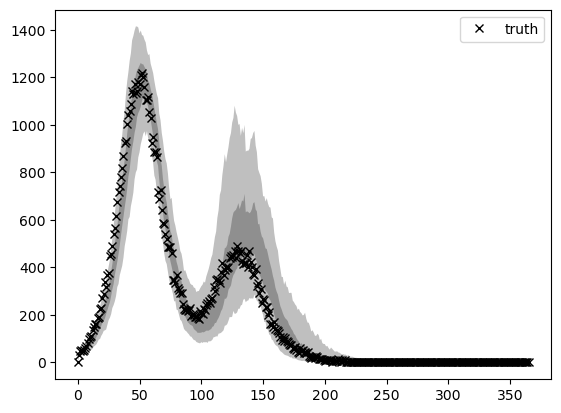

In [112]:
# plt.plot(i, '-.', alpha=0.1, color='grey')
plt.fill_between(np.arange(0,366), ci[0], ci[1], facecolor='gray', alpha=0.5)
plt.fill_between(np.arange(0,366), ci_50[0], ci_50[1], facecolor='gray', alpha=0.75)
plt.plot(data.i_true, 'x', color='black', label="truth")
plt.legend(loc="upper right")

Percent of observations in 95% CI 81.97%
Percent of observations in 50% CI 48.36%


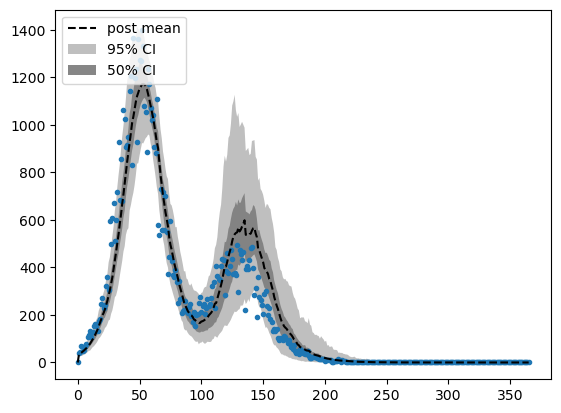

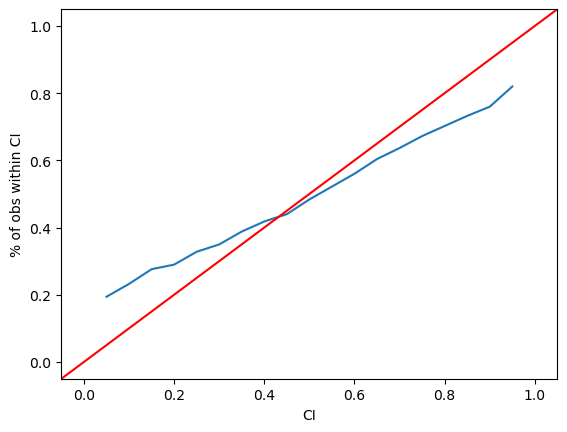

In [113]:
plot_reliability(θ_list)

# Try running the model from the beginning for each assimilation step